<a href="https://colab.research.google.com/github/iu5git/Deep-learning/blob/main/notebooks/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Лабораторная работа №6

# Задание



Необходимо сгенерировать синтетические данные и обучить на них модель авторегрессии, модель авторегрессии с методом главных компонент, модель LSTM.

Обучить рекуррентную нейронную сеть на реальных данных погоды по варианту.

Отчет должен содержать: титульный лист, задание с вариантом, скриншоты и краткие пояснения по каждому этапу лабораторной работы. Результаты моделей авторегрессии, LSTM на систетических данных, а также результаты обучения на реальных данных.

Вариант города соответствует группе: 1 - Москва, 2 - Санкт-Петербург, 3 - Новосибирск, 4 - Екатеринбург

#Контрольные вопросы
1. Что такое временной ряд
2. Рекуррентная нейронная сеть
3. LSTM, GRU
4. Авторегрессия

# Импорт библиотек

In [ ]:
#!pip install torchsummary
import time
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Часть 1 (Синтетические данные)

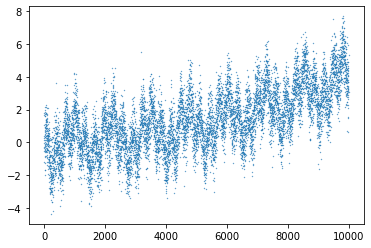

In [ ]:
X = np.arange(10000)
y = np.sin(X/50)-np.sin(X/200)+(2*X/X.size)**2
y += np.random.normal(scale=1.0, size=y.size)
plt.scatter(X, y[:10000], s=0.1)

df = pd.Series(y)
df = df.diff().dropna()

In [ ]:
def getWindows(x):
    X.append(x.values.copy())
    return 0

WINDOW_SIZE = 200
X = []
df.rolling(WINDOW_SIZE+1).apply(getWindows)
X = np.array(X)
y = X[:, WINDOW_SIZE:].copy()
X = X[:, :WINDOW_SIZE].copy()
X.shape, y.shape

((9799, 200), (9799, 1))

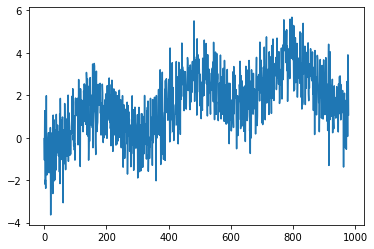

In [ ]:
X_train = X[:X.shape[0]*9//10].copy()
y_train = y[:y.shape[0]*9//10].copy()
#y_train -= X_train[:, -1:]

X_test = X[X.shape[0]*9//10:].copy()
y_test = y[y.shape[0]*9//10:].copy()
#y_test -= X_test[:, -1:]

plt.plot(np.cumsum(y_test))

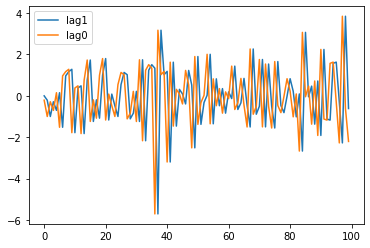

In [ ]:
plt.plot(X_test[-100:,-1], label='lag1')
plt.plot(y_test[-100:], label='lag0')
plt.legend()

### Модель авторегрессии (AR)

In [ ]:
def time_series_score(y_true, y_pred, X_true):
    true_values = y_true#X_true[:, -1] + y_true
    pred_values = y_pred#X_true[:, -1] + y_pred

    last_value = X_true[:,-1].copy()
    variance_dummy = ((last_value - true_values)**2).mean()
    variance_pred = ((pred_values - true_values)**2).mean()
    #print(variance_dummy, variance_pred)
    r2 = 1 - variance_pred/variance_dummy
    #r2_adj = 1 - (1-r2)*(y_true.size - 1)/(y_true.size - X_true.shape[1] - 1)
    return r2

def recursive_predict(model, X):
   preds = []
   length = X.shape[0]
   last_vals = X[0].copy()
   for i in range(length):
      preds.append(model.predict([last_vals]))
      #tmp = last_vals[-1].copy() 
      last_vals[:-1] = last_vals[1:]
      last_vals[-1:] = preds[-1] # + tmp
   return np.array(preds).reshape(-1)

  0%|          | 0/200 [00:00<?, ?it/s]

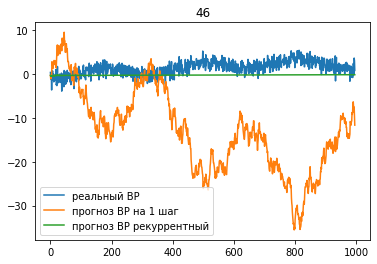

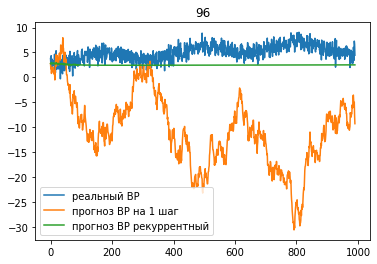

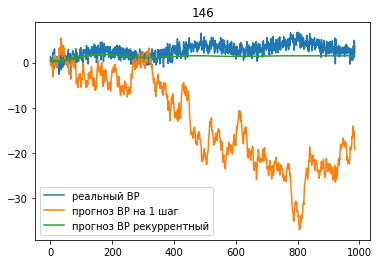

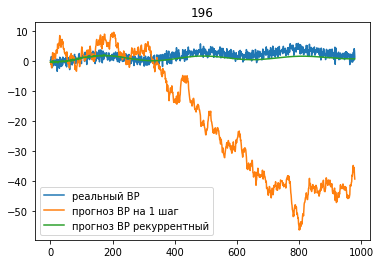

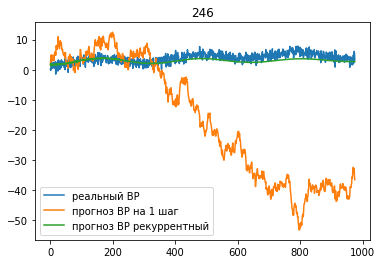

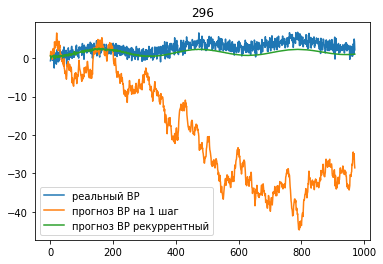

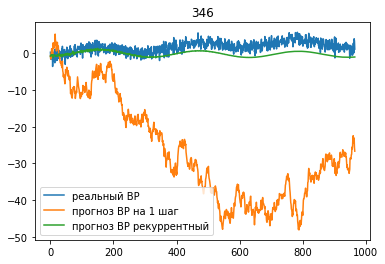

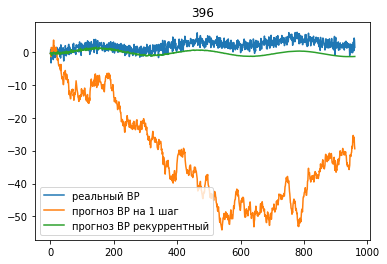

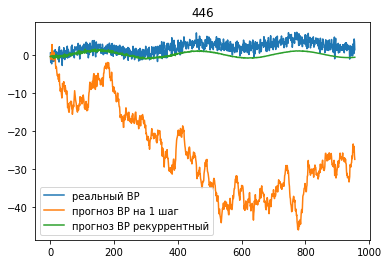

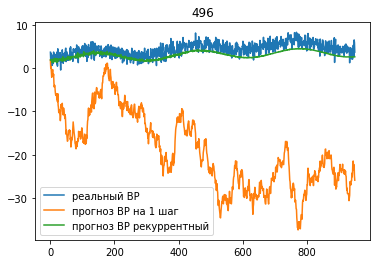

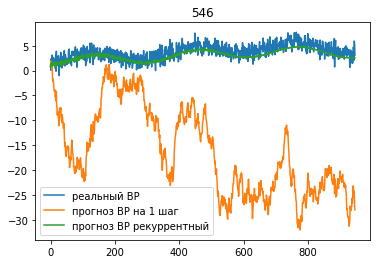

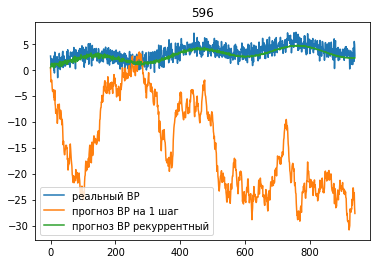

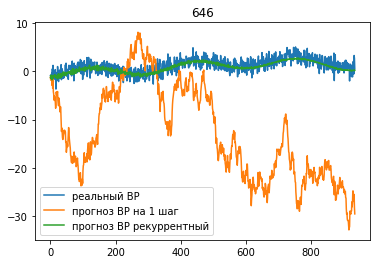

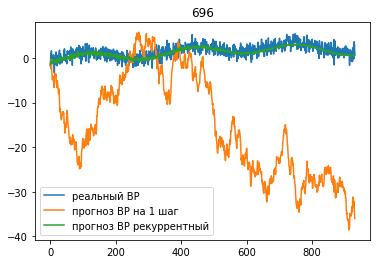

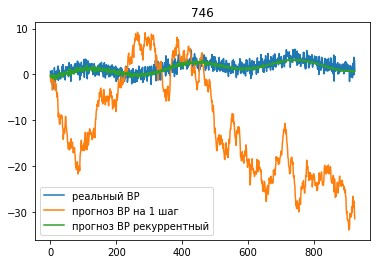

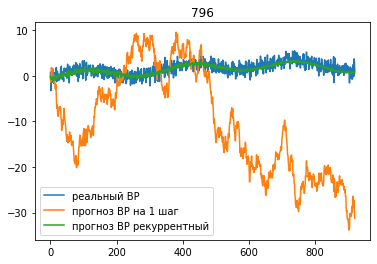

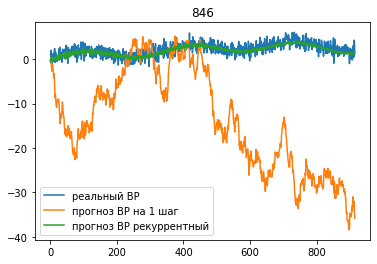

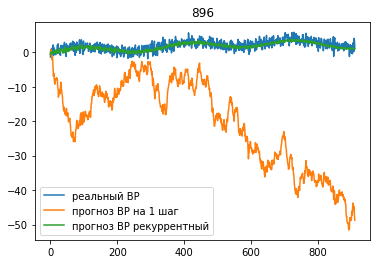

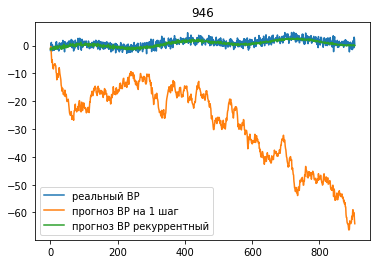

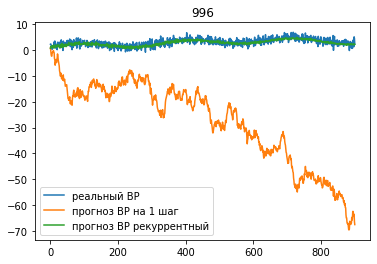

In [ ]:
stats = []
series = []

windows = np.arange(1, 1001, 5)
for w in tqdm(windows):
    WINDOW_SIZE = w
    X = []
    df.rolling(WINDOW_SIZE+1).apply(getWindows)
    X = np.array(X)
    y = X[:, WINDOW_SIZE:].copy()
    X = X[:, :WINDOW_SIZE].copy()

    X_train = X[:X.shape[0]*9//10].copy()
    y_train = y[:y.shape[0]*9//10].copy()
    #y_train -= X_train[:, -1:]

    X_test = X[X.shape[0]*9//10:].copy()
    y_test = y[y.shape[0]*9//10:].copy()
    #y_test -= X_test[:, -1:]

    lr = LinearRegression().fit(X_train, y_train)

    #preds = lr.predict(X_test)
    #preds = recursive_predict(lr, X_test)    
    tmp = []
    p = [lr.predict(X_test), recursive_predict(lr, X_test)]
    for preds in p:
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        tss = time_series_score(y_test, preds, X_test)
        tmp.extend([mae, r2*100, tss*100])
    stats.append(tmp)
    series.append(preds)
    if (len(stats)%10)==0:
        plt.plot(np.cumsum(y_test), label='реальный ВР')
        plt.plot(np.cumsum(p[0]), label='прогноз ВР на 1 шаг')
        plt.plot(np.cumsum(p[1]), label='прогноз ВР рекуррентный')
        plt.title(str(WINDOW_SIZE))
        plt.ylim(np.cumsum(y_test).min()*1.5, np.cumsum(y_test).max()*1.5)
        plt.legend(loc=0)
        plt.show()

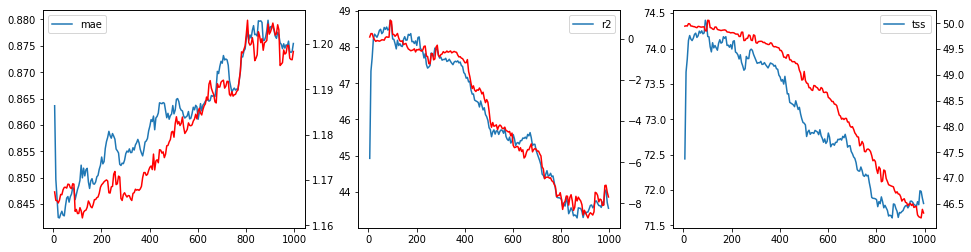

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(windows[1:], np.array(stats)[1:,0], label='mae')
ax[1].plot(windows[1:], np.array(stats)[1:,1], label='r2')
ax[2].plot(windows[1:], np.array(stats)[1:,2], label='tss')

ax[0].twinx().plot(windows[1:], np.array(stats)[1:,3], c='r', label='mae rec')
ax[1].twinx().plot(windows[1:], np.array(stats)[1:,4], c='r', label='r2 rec')
ax[2].twinx().plot(windows[1:], np.array(stats)[1:,5], c='r', label='tss rec')

for ax_ in ax:
    ax_.legend()

### Модель авторегрессии с методом главных компонент (AR+PCA)
структурная декомпозиция

In [ ]:
def time_series_score_pca(y_true, y_pred, X_true, pca):
    true_values = y_true#pca.inverse_transform(X_true)[:, -1] 
    pred_values = y_pred#pca.inverse_transform(X_true)[:, -1]

    last_value = pca.inverse_transform(X_true)[:,-1].copy()
    variance_dummy = ((last_value - true_values)**2).mean()
    variance_pred = ((pred_values - true_values)**2).mean()
    #print(variance_dummy, variance_pred)
    r2 = 1 - variance_pred/variance_dummy
    #r2_adj = 1 - (1-r2)*(y_true.size - 1)/(y_true.size - X_true.shape[1] - 1)
    return r2

def recursive_predict_pca(model, X, pca):
    preds = []
    length = X.shape[0]
    last_vals = pca.inverse_transform(X)[0].copy()
    for i in range(length):
        preds.append(model.predict(pca.transform([last_vals])))
        last_vals[:-1] = last_vals[1:]
        last_vals[-1:] = preds[-1]
    return np.array(preds).reshape(-1)
    # preds = []
    # length = X.shape[0]
    # last_vals = pca.inverse_transform(X)[0].copy()
    # for i in range(length):
    #     preds.append(model.predict(pca.transform([last_vals])))
    #     tmp = pca.transform([last_vals])[0, -1] 
    #     last_vals[:-1] = last_vals[1:]
    #     last_vals[-1:] = tmp + preds[-1]
    # return np.array(preds).reshape(-1)

  0%|          | 0/200 [00:00<?, ?it/s]

[0.8429323434298995, 48.30210126153539, 74.1216456780982, 1.1684127061585803, -0.1328322994669895, 49.93455672450244]


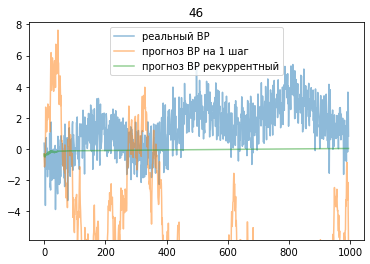

[0.8475138143751241, 48.530001626743235, 74.2944414051953, 1.1634144080026767, 0.8444950231221049, 49.84570133765859]


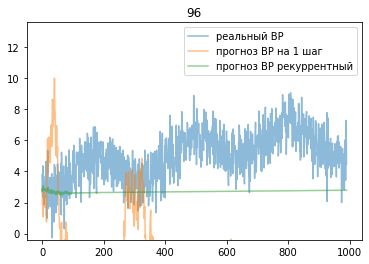

[0.8549919428653824, 47.415417349039856, 73.67697986502908, 1.1652492028415422, -0.2773958799466181, 49.87120931494569]


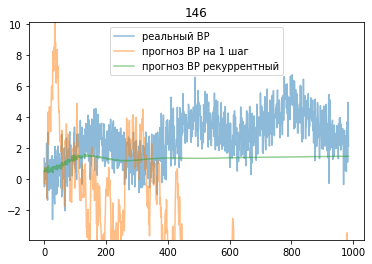

[0.854463249595564, 47.94351765194341, 73.94128797808912, 1.1683368101951361, -0.641455359247467, 49.81557638769398]


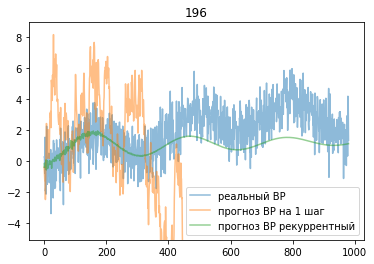

[0.8585802502180898, 47.400257378462165, 73.7453672383377, 1.16853371741665, -0.8694701254661208, 49.83049033967134]


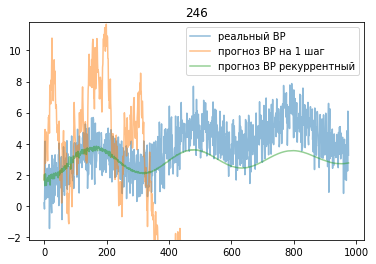

[0.8583617503046197, 47.18094176090023, 73.61885458428752, 1.1672101469013894, -0.8977501668051113, 49.76143317980851]


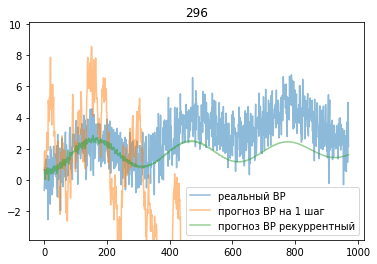

[0.857132516775597, 47.432123141469184, 73.68629577605385, 1.1677286840393983, -0.6957826330497685, 49.60205112746073]


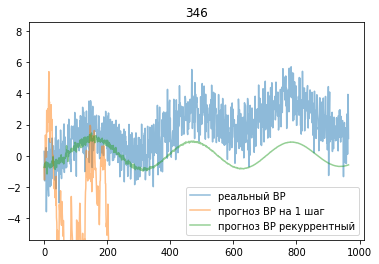

[0.8608654855600174, 47.009422688222124, 73.48054431864774, 1.1721991052290281, -1.0754000516872253, 49.525190857340476]


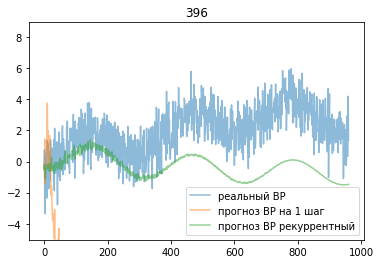

[0.8642044439860546, 46.31927631521226, 73.13151736780937, 1.176527876212387, -2.560363122311249, 49.29271359795987]


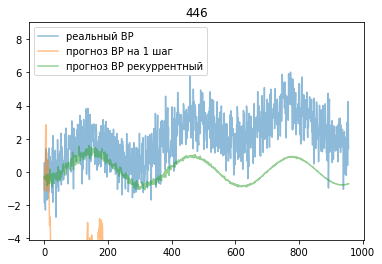

[0.8636886995970886, 45.83702849656588, 72.88658680335908, 1.1807038111879504, -3.087986972665524, 48.911069044461456]


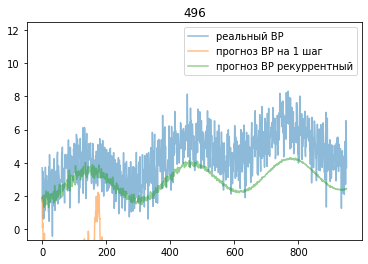

[0.8591613717409072, 45.58683488839005, 72.80034334640177, 1.180798583832309, -4.22070873446172, 48.79147766282905]


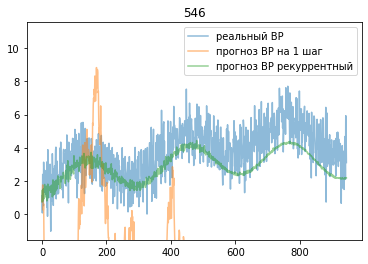

[0.8642211698591965, 44.909590801363606, 72.43970273165532, 1.1835090241249562, -4.593108532168211, 48.66146309793628]


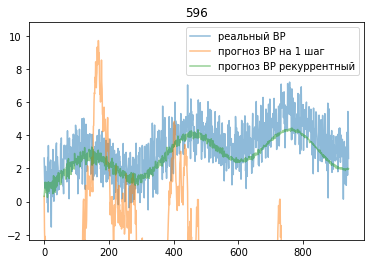

[0.8666612850057213, 44.97496429932048, 72.46064313599983, 1.1912650199593255, -5.788813486053379, 48.21669840440131]


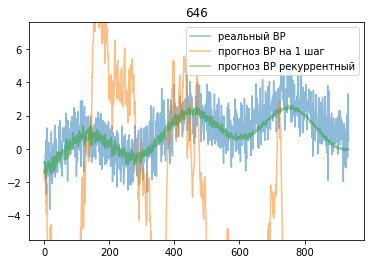

[0.8735723163330104, 44.78837551652857, 72.36432211246215, 1.1913919022034891, -5.362463531372774, 47.97950684138741]


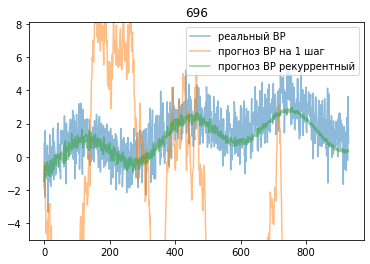

[0.86796889617588, 44.1102194022075, 72.04040482718457, 1.1884968141224284, -6.721945931473061, 47.655484135948946]


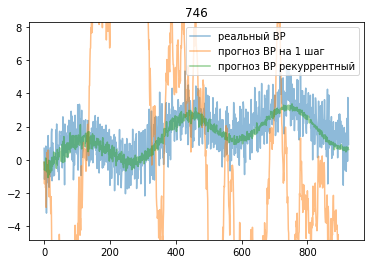

[0.874511366036578, 43.71970791716016, 71.82372997853984, 1.199705987811866, -7.4971579498099405, 47.31937219175029]


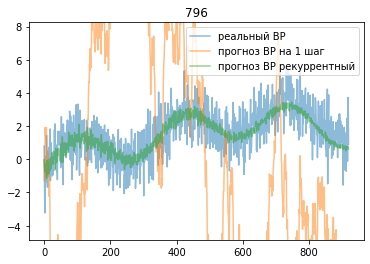

[0.8775628693757505, 43.482182480793405, 71.70840301026008, 1.1976155686222782, -7.870080308974248, 46.936544768157184]


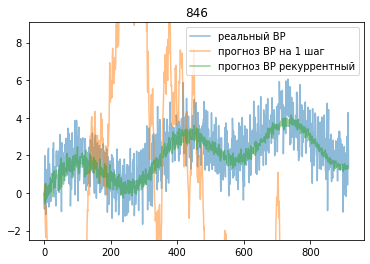

[0.8784010835397182, 43.458097541465676, 71.69659906449608, 1.2022960049746967, -8.348440445778959, 46.687055284951164]


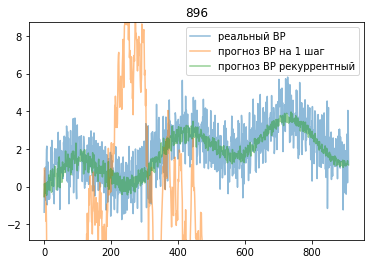

[0.8758778858142192, 43.83754188446382, 71.88915479430051, 1.1956569341672607, -7.502741241033628, 46.47205388574076]


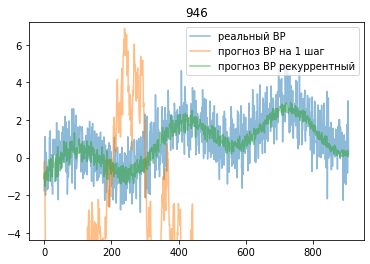

[0.8765764598620174, 43.62639919794985, 71.85013769525592, 1.1982290551192696, -7.664725120111804, 46.32023645274319]


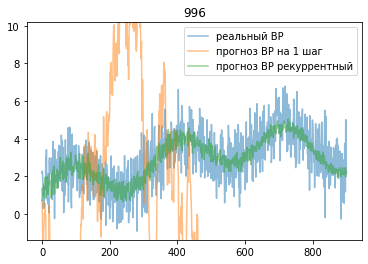

In [ ]:
stats = []
series = []

windows = np.arange(1, 1001, 5)
for w in tqdm(windows):
    WINDOW_SIZE = w
    X = []
    df.rolling(WINDOW_SIZE+1).apply(getWindows)
    X = np.array(X)
    y = X[:, WINDOW_SIZE:].copy()
    X = X[:, :WINDOW_SIZE].copy()

    X_train = X[:X.shape[0]*9//10].copy()
    y_train = y[:y.shape[0]*9//10].copy()
    #y_train -= X_train[:, -1:]

    X_test = X[X.shape[0]*9//10:].copy()
    y_test = y[y.shape[0]*9//10:].copy()
    #y_test -= X_test[:, -1:]

    pca = PCA(n_components=max(1, WINDOW_SIZE-1),#//5), # 20% по Паретто
              random_state=0).fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    lr = LinearRegression().fit(X_train, y_train)

    #preds = lr.predict(X_test)
    #preds = recursive_predict(lr, X_test)    
    tmp = []
    p = [lr.predict(X_test), recursive_predict_pca(lr, X_test, pca)]
    for preds in p:
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        tss = time_series_score_pca(y_test, preds, X_test, pca)
        tmp.extend([mae, r2*100, tss*100])
    stats.append(tmp)
    series.append(preds)
    if (len(stats)%10)==0:
        plt.plot(np.cumsum(y_test), alpha=0.5, label='реальный ВР')
        plt.plot(np.cumsum(p[0]), alpha=0.5, label='прогноз ВР на 1 шаг')
        plt.plot(np.cumsum(p[1]), alpha=0.5, label='прогноз ВР рекуррентный')
        plt.ylim(np.cumsum(y_test).min()*1.5, np.cumsum(y_test).max()*1.5)
        plt.title(str(WINDOW_SIZE))
        plt.legend(loc=0)
        print(stats[-1])
        plt.show()

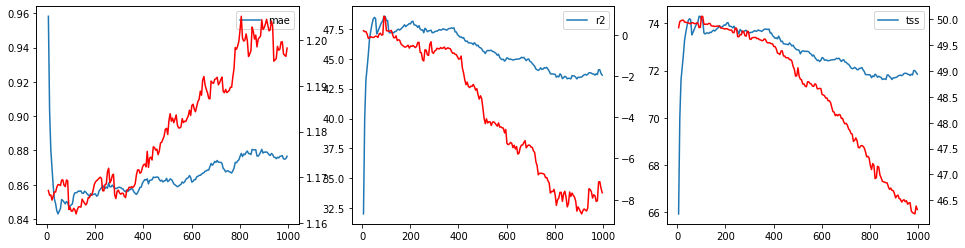

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(windows[1:], np.array(stats)[1:,0], label='mae')
ax[1].plot(windows[1:], np.array(stats)[1:,1], label='r2')
ax[2].plot(windows[1:], np.array(stats)[1:,2], label='tss')

ax[0].twinx().plot(windows[1:], np.array(stats)[1:,3], c='r', label='mae rec')
ax[1].twinx().plot(windows[1:], np.array(stats)[1:,4], c='r', label='r2 rec')
ax[2].twinx().plot(windows[1:], np.array(stats)[1:,5], c='r', label='tss rec')

for ax_ in ax:
    ax_.legend()

### LSTM

In [ ]:
WINDOW_SIZE = 750
X = []
df.rolling(WINDOW_SIZE+1).apply(getWindows)
X = np.array(X)
y = X[:, WINDOW_SIZE:].copy()
X = X[:, :WINDOW_SIZE].copy()
X_train = X[:X.shape[0]*9//10].copy()
y_train = y[:y.shape[0]*9//10].copy()

X_test = X[X.shape[0]*9//10:].copy()
y_test = y[y.shape[0]*9//10:].copy()

In [ ]:
#MAX_VAL = np.abs(y_train).max()
tensor_X_train = torch.autograd.Variable(torch.Tensor(X_train))
tensor_y_train = torch.autograd.Variable(torch.Tensor(y_train))

tensor_X_test = torch.autograd.Variable(torch.Tensor(X_test))
tensor_y_test = torch.autograd.Variable(torch.Tensor(y_test))

dataset = TensorDataset(tensor_X_train, tensor_y_train)

dataset_test = TensorDataset(tensor_X_test, tensor_y_test)

dataloader = {}
dataloader['train'] = DataLoader(dataset, batch_size=1024, shuffle=True)
dataloader['test'] = DataLoader(dataset_test, batch_size=128, shuffle=True)
del dataset, dataset_test

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.autograd.Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = torch.autograd.Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
learning_rate = 0.1

input_size = 1
hidden_size = 4
num_layers = 1

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # среднекврадратическое отклонение
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# добавляем постепенное уменьшение шага обучения каждые 200 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

Эпоха: 40
Лучший коэффициент детерминации: 1.0656966045498848
Текущий коэффициент детерминации: 1.086957149207592


  0%|          | 0/360 [00:00<?, ?it/s]

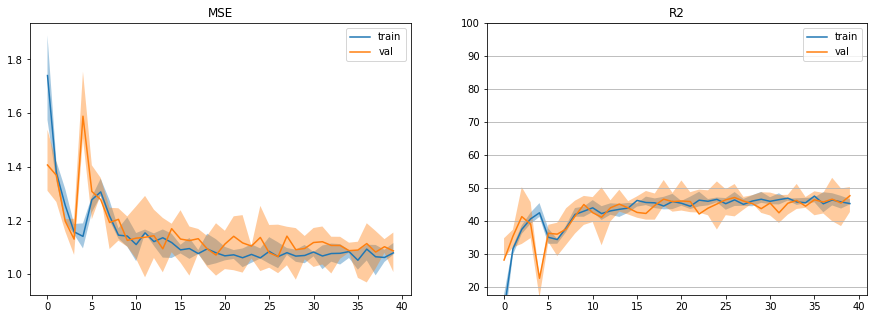

Обучение закончено за 399.3893196582794 секунд


In [ ]:
EPOCHS = 40
REDRAW_EVERY = 1
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
# для создания чекпоинта
best_loss = np.inf
checkpoint_path = 'ts.pth' 
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs.view(-1, X_test.shape[1], 1))
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = 100*r2_score(labels.detach().numpy(), outputs.detach().numpy())
        tmp.append((loss.item(), accuracy))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    scheduler.step() # обновляем learning_rate каждую эпоху
    tmp = []
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs.view(-1, X_test.shape[1], 1))
            loss = criterion(outputs, labels)
            accuracy = 100*r2_score(labels.detach().numpy(), outputs.detach().numpy())
            tmp.append((loss.item(), accuracy))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    # сохранение чекпоинта
    loss = losses_val[-1][0][0]
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), checkpoint_path)
    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    print('Эпоха: %s\n'
          'Лучший коэффициент детерминации: %s\n'
          'Текущий коэффициент детерминации: %s' % (epoch+1, best_loss, loss))
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['MSE', 'R2']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
model.load_state_dict(torch.load(checkpoint_path))
print('Обучение закончено за %s секунд' % passed)

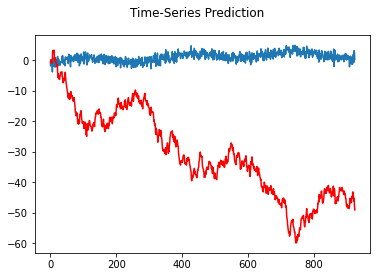

In [ ]:
model.eval()
train_predict = model(tensor_X_test.view(-1, WINDOW_SIZE, 1))

data_predict = train_predict.data.numpy()#*MAX_VAL
dataY_plot = tensor_y_test.data.numpy()#*MAX_VAL

plt.plot(np.cumsum(dataY_plot))
plt.plot(np.cumsum(data_predict), color='r')
plt.suptitle('Time-Series Prediction')
plt.show()

  0%|          | 0/925 [00:00<?, ?it/s]

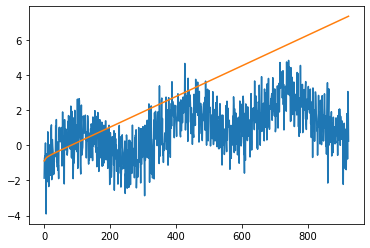

In [ ]:
# Рекуррентный прогноз
model.eval()
last_value = tensor_X_test[0].clone()
preds = []
with torch.no_grad():
    for i in tqdm(range(y_test.shape[0])):
        preds.append(model(last_value.view(-1, WINDOW_SIZE, 1)).detach().item())
        last_value[:-1] = last_value[1:].clone()
        last_value[-1:] = preds[-1]
preds = np.array(preds)# * MAX_VAL
plt.plot(np.cumsum(y_test))
plt.plot(np.cumsum(preds))

## Часть 2 (Реальные данные)

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1FtEVU702DjlTjoecxbbNBl5nP9SCu7Rw

Retrieving folder list
Processing file 1mBIyf4Zo4ChrQ0R6EvwdrkQzrAKpX27c climate_ekb.csv
Processing file 1B0RgTX4TN8WuLkXins8D1pnrdhntHPXQ climate_moscow.csv
Processing file 18AVqfU6mtCwuqkuC6feZs9slE-WJk9MU climate_novosib.csv
Processing file 12SudJ27Zzxrd2eg4wsMDrfDQMTkacuFL climate_piter.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1mBIyf4Zo4ChrQ0R6EvwdrkQzrAKpX27c
To: /content/climate/climate_ekb.csv
100% 3.75M/3.75M [00:00<00:00, 190MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B0RgTX4TN8WuLkXins8D1pnrdhntHPXQ
To: /content/climate/climate_moscow.csv
100% 3.70M/3.70M [00:00<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=18AVqfU6mtCwuqkuC6feZs9slE-WJk9MU
To: /content/climate/climate_novosib.csv
100% 3.73M/3.73M [00:00<00:00, 219MB/s]
Downloading...
From: https://drive.google.com/uc?id=12SudJ27Zzxrd2eg4wsMDrfDQMTkacuFL
To: /content/climate/

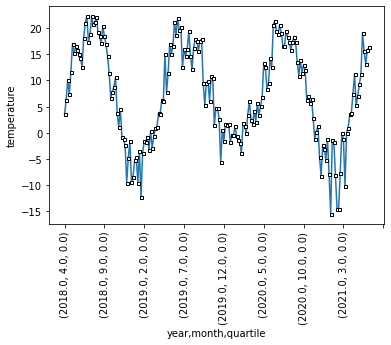

In [ ]:
# По варианту проделать те же шаги для набора данных с погодой за полвека
df = pd.read_csv('climate/climate_moscow.csv', sep='\t')
df = df[df.year>1972].copy()
df['quartile'] = df.day//7
df.groupby(['year', 'month', 'quartile']).\
   Temperature.\
   aggregate('mean').\
   iloc[-4*12*4:].\
   plot(rot=90, ylabel='temperature',
        marker='s',
        markersize=3,
        markerfacecolor='white',
        markeredgecolor='k')
df = df.Temperature.diff().dropna()